In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, Dense, Dropout, Flatten, Input, Conv2D

In [ ]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# print('Device:', tpu.master())
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)
# clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Datasets/COVID-19_X-ray-Dataset.zip
clear_output()

In [ ]:
def split(data_path):
  os.mkdir("dataset")
  os.mkdir("dataset/train")
  os.mkdir("dataset/test")
  os.mkdir("dataset/val")
  for i in ['COVID','Normal','Viral Pneumonia']:
    os.mkdir(f"dataset/train/{i}")
    os.mkdir(f"dataset/test/{i}")
    os.mkdir(f"dataset/val/{i}")
    cat_path = os.path.join(data_path,i)
    filenames = os.listdir(cat_path)
    random.seed(2021)
    random.shuffle(filenames)
    train, test = train_test_split(filenames, test_size=0.2)
    test, val = train_test_split(test, test_size=0.5)
    for file in tqdm(train):
      shutil.copy(f"{cat_path}/{file}", f"dataset/train/{i}/{file}")
    for file in tqdm(test):
      shutil.copy(f"{cat_path}/{file}", f"dataset/test/{i}/{file}")
    for file in tqdm(val):
      shutil.copy(f"{cat_path}/{file}", f"dataset/val/{i}/{file}")


In [ ]:
split("/content/COVID-19_X-ray-Dataset")

100%|██████████| 522/522 [00:00<00:00, 829.88it/s]


In [ ]:
import glob
print("Train:",len(glob.glob("dataset/train/*/*")))
print("Test:",len(glob.glob("dataset/test/*/*")))
print("Val:",len(glob.glob("dataset/val/*/*")))

Train: 12180
Test: 1522
Val: 1524


In [ ]:
IMAGE_SIZE = 180
BATCH_SIZE = 64 #* strategy.num_replicas_in_sync
generator = ImageDataGenerator(rescale=1./255)

X_train = generator.flow_from_directory(
    "dataset/train",
    target_size = (180,180),
    batch_size = BATCH_SIZE
)

X_test = generator.flow_from_directory(
    "dataset/test",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

X_val = generator.flow_from_directory(
    "dataset/val",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 12180 images belonging to 3 classes.
Found 1522 images belonging to 3 classes.
Found 1524 images belonging to 3 classes.


In [ ]:
X_test.class_indices

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [ ]:
X_test.class_indices

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [ ]:
def conv_block(filters):
  block = tf.keras.Sequential([
                               SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
                               SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
                               BatchNormalization(),
                               MaxPool2D()
  ])
  return block

In [ ]:
def dense_block(units, dropout):
  block = tf.keras.Sequential([
                               Dense(units, activation='relu'),
                               BatchNormalization(),
                               Dropout(dropout)
  ])
  return block

In [ ]:
def build_model():
  model = tf.keras.Sequential([
                               Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
                               Conv2D(16, (3,3), activation='relu', padding='same'),
                               Conv2D(16, (3,3), activation='relu', padding='same'),
                               MaxPool2D(),

                               conv_block(32),
                               conv_block(64),
                               conv_block(128),
                               Dropout(0.2),
                               conv_block(256),
                               Dropout(0.2),
                               
                               Flatten(),
                               dense_block(512, 0.5),
                               dense_block(256, 0.3),
                               dense_block(128, 0.2),
                               Dense(3, activation='softmax')
  ])
  return model

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5", save_best_only=True, verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)

In [ ]:
#with strategy.scope():
METRICS = [
          'accuracy',
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
]

CALLBACKS = [
            checkpoint_cb,
            early_stopping_cb,
            lr_scheduler
]

In [ ]:
#with strategy.scope():
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)     

In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit_generator(
      X_train,
      validation_data=X_val,
      epochs=25,
      callbacks=CALLBACKS
  )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
191/191 [==============================] - 98s 497ms/step - loss: 0.5825 - accuracy: 0.7512 - precision: 0.7753 - recall: 0.7423 - val_loss: 2.1018 - val_accuracy: 0.4829 - val_precision: 0.4797 - val_recall: 0.4718

Epoch 00001: val_loss did not improve from 1.12836
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.008912509381337455.
191/191 [==============================] - 94s 489ms/step - loss: 0.3774 - accuracy: 0.8442 - precision: 0.8486 - recall: 0.8374 - val_loss: 26.8722 - val_accuracy: 0.2828 - val_precision: 0.2828 - val_recall: 0.2828

Epoch 00002: val_loss did not improve from 1.12836
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.007943282347242816.
191/191 [==============================] - 94s 489ms/step - loss: 0.2973 - accuracy: 0.8784 - precision: 0.8821 - recall: 0.8750 - val_loss: 0.3548 - val_accuracy: 0.8524 - val_precision: 0.8547 - 

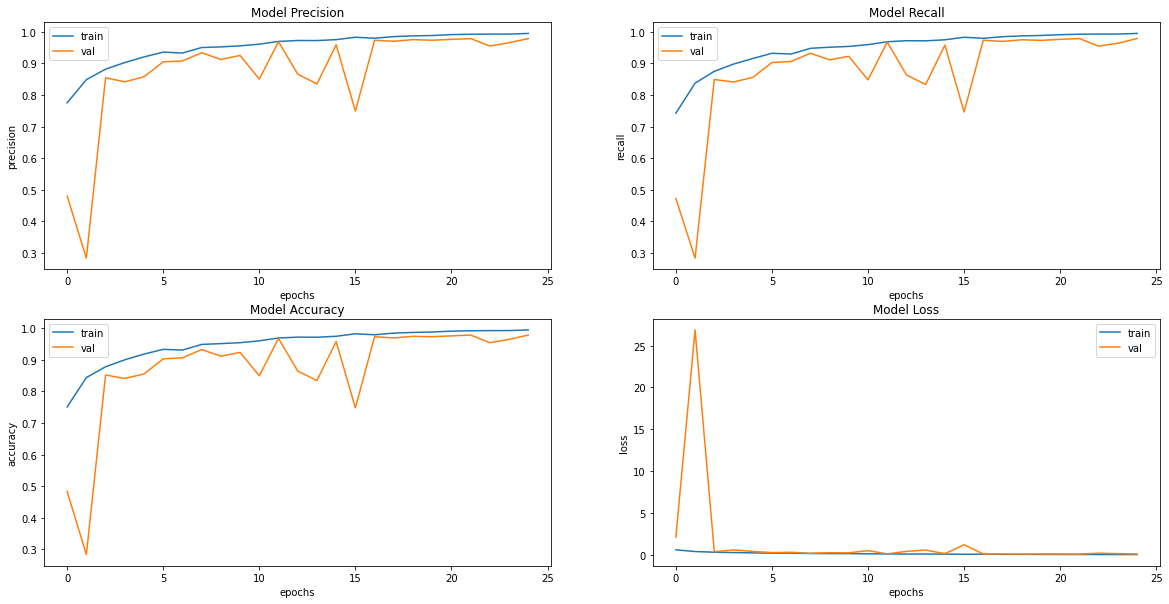

In [ ]:
plt.figure(figsize=(20,10))

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  plt.subplot(2,2,i+1)
  plt.plot(history.history[met])
  plt.plot(history.history["val_"+met])
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [ ]:
model.evaluate(X_test)

24/24 [==============================] - 9s 361ms/step - loss: 0.0913 - accuracy: 0.9731 - precision: 0.9731 - recall: 0.9731


[0.0913393497467041, 0.973061740398407, 0.973061740398407, 0.973061740398407]

In [ ]:
tt = tf.keras.models.load_model("checkpoint_model.h5")
tt.evaluate(X_test)

24/24 [==============================] - 10s 385ms/step - loss: 0.0804 - accuracy: 0.9731 - precision: 0.9730 - recall: 0.9717


[0.08041353523731232,
 0.973061740398407,
 0.9730263352394104,
 0.9717476963996887]

In [ ]:
!cp checkpoint_model.h5 gdrive/MyDrive/Covid-Pneumonia_Detection_Model/covid_pneumonia_detection_model.h5

In [ ]:
import cv2
import numpy as np

In [ ]:
img1 = cv2.resize(cv2.imread("c1.jpg"), (180,180))/255.0
img2 = cv2.resize(cv2.imread("c2.jpg"), (180,180))/255.0
img3 = cv2.resize(cv2.imread("n1.jpg"), (180,180))/255.0
img4 = cv2.resize(cv2.imread("p1.jpg"), (180,180))/255.0

x = np.array([img1,img2,img3,img4])

In [ ]:
model3 = tf.keras.models.load_model("drive/MyDrive/Covid-Pneumonia_Detection_Model/covid_pneumonia_detection_model.h5")
model3.predict(x)

array([[9.9955028e-01, 3.9690844e-04, 5.2803764e-05],
       [9.9996936e-01, 2.7761471e-05, 2.8562476e-06],
       [9.9433988e-01, 5.4468261e-03, 2.1330340e-04],
       [9.9937743e-01, 6.1128475e-04, 1.1328808e-05]], dtype=float32)

In [ ]:
np.argmax(model3.predict(x),axis=-1)

array([0, 0, 0, 0])

In [ ]:
imgn = cv2.resize(cv2.imread("p1.jpg"), (180,180))/255.0
x1 = np.expand_dims(imgn, axis=0)

In [ ]:
x1.shape

(1, 180, 180, 3)

In [ ]:
model3.predict(x1)

array([[9.9937743e-01, 6.1128451e-04, 1.1328786e-05]], dtype=float32)

In [ ]:
np.argmax(model3.predict(x1),axis=-1)

array([0])